# An√°lise do desempenho do modelo de detec√ß√£o de viol√™ncia

[Voltar ao √çndice](00_indice.ipynb)

Nosso objetivo √© verificar se o modelo de IA utilizado neste projeto est√° estimando corretamente os n√≠veis de viol√™ncia e se essa estimativa √© adequada para diversos grupos sociais e tipos de viol√™ncia.
Para tanto, vamos utilizar novas anota√ß√µes de tweets feitas por parceiros.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from glob import glob
from functools import partial
from multiprocessing import Pool
from importlib import reload
import matplotlib.lines as mlines

import src.tweet_analysis as com
import src.analysis_functions as af
import xavy.dataframes as xd
import xavy.drive as dr
import xavy.stats as xs
import xavy.plots as xp
import xavy.mltools as ml
import xavy.utils as xu

/home/hxavier/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


**ATEN√á√ÉO:** √â preciso eliminar a contagem dupla caso dois anotadores sejam a mesma pessoa.

## Carregando classifica√ß√µes feitas pela m√°quina

In [2]:
# Lista arquivos a serem anotados por cada grupo, ainda vazios:
sample_files = glob('../dados/processados/amostra_tweets_para_anotacao_*.csv')
# Carrega IDs do tweets de cada grupo:
sampled_tweets_raw_df = pd.concat([af.load_group_data(f) for f in sample_files], ignore_index=True)

In [3]:
# Contabiliza grupos que foram alocados a cada tweet:
sampled_tweets_raw_df['n'] = 1
sampled_tweets_df = sampled_tweets_raw_df.pivot_table(index='id', columns='grupo', values='n', aggfunc='sum').fillna(0).astype(int)
sampled_tweets_df['n_grupos'] = sampled_tweets_df.sum(axis=1)

In [4]:
# N√∫m. de tweets no bin de score na amostra original:
sampled_bin_counts = sampled_tweets_raw_df.groupby('id')['n_prob_bin'].max()

In [5]:
# Carrega os tweets:
reload_tweets = False
tweet_selection_file = '../dados/processados/amostra_tweets_escolhidos_para_anotacao.csv'

if reload_tweets is True:
    # Carrega as configura√ß√µes:
    config = com.read_config()

    # Load tweets:
    tweets_df = com.etl_tweets_df(config['scored_tweets_dir'], config['target_model'], config['bad_users'])
    # Filter tweets directed to a single person:
    direct_df = com.select_direct_text_tweets(tweets_df)

    # Select tweets that were chosen for annotation:
    tweet_cols = ['id', 'created_at', 'text', 'tweet_url', 'direct_reply', 'batch_user', 'hate_score', 'target_prob']
    tweets4annotation_df = direct_df.loc[direct_df['id'].isin(sampled_tweets_df.index), tweet_cols]
    
    # Salva os tweets selecionados, para evitar ter que carregar tudo de novo:
    #tweets4annotation_df.to_csv(tweet_selection_file, index=False)

else:
    # Carrega tweets j√° selecionados:
    tweets4annotation_df = pd.read_csv(tweet_selection_file)

assert xd.iskeyQ(tweets4annotation_df[['id']])

## Carregando e preparando as anota√ß√µes feitas

Para podermos carregar uma planilha do google sheets diretamente, precisamos que ela d√™ acesso ao seguinte usu√°rio:
 `violentometro-sheets@ceweb-xavier.iam.gserviceaccount.com`

In [6]:
# Atualiza a lista de sheets com anota√ß√µes a partir do Google Sheets:
dir_df = dr.load_data_from_local_or_drive('https://docs.google.com/spreadsheets/d/1C_eDa4JUcSuKXNJ8c5cI_3aOSMiDlX-hRsVz71WUZz4', 
                                          '../dados/brutos/aux/tabela_planilhas_tweets_anotados.csv', force_drive=False)
print(xd.bold('Repeti√ß√£o de anotadores'))
xd.check_guarda_compartilhada(dir_df, 'Respons√°vel', 'Anotador')

Loading data from local file...
Repeti√ß√£o de anotadores


Respons√°vel
Xavier    [A06, A09, A10, A13]
Name: Anotador, dtype: object

In [7]:
ignore_annotators = ['A13']

# Junta as anota√ß√µes aos tweets:
tweets_annotated_df = tweets4annotation_df
for grupo in dir_df['Grupo'].drop_duplicates():
    print('* Grupo: {}'.format(grupo))
    # Carrega dados de cada anotador dentro de um grupo social:
    df = af.etl_group_annotations(dir_df, grupo, force_drive=False)
    tweets_annotated_df = tweets_annotated_df.join(df, how='outer', on='id')

n_unmatched = tweets_annotated_df['created_at'].isnull().sum()
assert n_unmatched == 0, 'Tivemos {} anotacoes que n√£o foram associadas a nenhum tweet.'.format(n_unmatched)

# Calcula a categoria final depois de usar majority voting 
af.summarize_annotations(tweets_annotated_df, ignore_annotators=ignore_annotators, defaults=[0, 0, 0, 0, 0])

# Verifica se dados est√£o OK:
print('')
af.security_checks(tweets_annotated_df)

tweets_annotated_df = tweets_annotated_df.join(sampled_tweets_df, on='id')

* Grupo: Pessoas negras
Loading data from local file...
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Mulheres
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: LGBTs
Loading data from local file...
Loading data from local file...
Loading data from local file...
* Grupo: Controle
Loading data from local file...
Loading data from local file...
Loading data from local file...

!! Os seguintes tweets n√£o possuem o mesmo n√∫mero de anota√ß√µes em todas as categorias: {674, 579, 644, 743, 1019, 1191, 237, 1198, 559, 787, 693, 86, 917, 88, 1430, 731, 412, 574}


In [8]:
for col in af.find_cols(tweets_annotated_df, 'cand_objeto_A'):
    print(col, tweets_annotated_df[col].unique())

cand_objeto_A01 [nan  1.  0.]
cand_objeto_A02 [nan  1.  0.]
cand_objeto_A03 [nan  1.  0.]
cand_objeto_A13 [nan  1.  0.]
cand_objeto_A04 [ 1. nan  0.]
cand_objeto_A05 [ 0. nan  1.]
cand_objeto_A06 [ 1. nan  0.]
cand_objeto_A07 [nan  1.  0.]
cand_objeto_A08 [nan  1.  0.]
cand_objeto_A09 [nan  1.  0.]
cand_objeto_A10 [nan  1.  0.]
cand_objeto_A11 [nan]
cand_objeto_A12 [nan]


### Estat√≠sticas das anota√ß√µes

In [8]:
# Contabiliza as anota√ß√µes para acompanhar o trabalho dos anotadores:
af.count_annotations_made(tweets_annotated_df)

label     cand_objeto  lgbtfobico  machista  racista  violento
anotador                                                      
A01               393         389       393      393       393
A02               394         394       394      394       395
A03               400         400       400      399       400
A04               400         399       400      400       400
A05               400         400       400      400       400
A06               400         400       400      400       400
A07               396         398       398      398       398
A08               397         397       396      395       398
A09               400         400       400      400       400
A10               400         400       400      400       400
A11                 0           0         0        0         0
A12                 0           0         0        0         0
A13               400         400       400      400       400

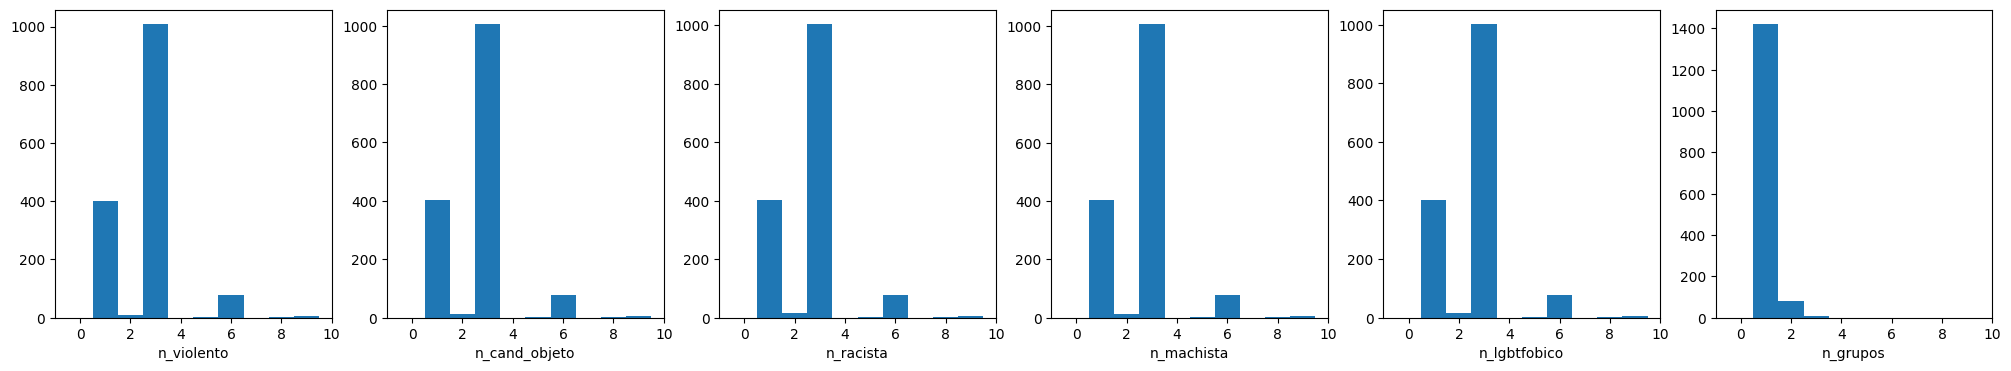

In [9]:
# N√∫mero de tweets com cada n√∫mero de anota√ß√µes feitas:
count_cols = af.find_cols(tweets_annotated_df, 'n_')
pl.figure(figsize=(25,4))
for i, col in enumerate(count_cols):
    pl.subplot(1, len(count_cols), i + 1)
    pl.hist(tweets_annotated_df[col], bins=np.arange(-0.5, 10.5, 1))
    pl.xlabel(col)
pl.show()

In [10]:
xd.print_string_series(tweets_annotated_df.query('cand_objeto_final == 0 and violento_final == 0').sample(3, random_state=3)['tweet_url'])

51: https://www.twitter.com/well11sp/status/1560283460576624641
664: https://www.twitter.com/MarliCella/status/1566483908652408834
1224: https://www.twitter.com/Kelly78637956/status/1574168831001436160


In [11]:
tweets_annotated_df['n_violento'].value_counts().sort_index()

1     402
2      10
3    1008
5       1
6      77
8       1
9       7
Name: n_violento, dtype: int64

In [13]:
len(tweets_annotated_df.query('n_violento >= 3'))

1094

## Concord√¢ncia entre anotadores

### Fleiss' Kappa

In [9]:
def compute_kappa(df):
    kappa = xs.fleiss_kappa(df.astype(int).values, N_classes=2, n_votes_per_class=False)
    return kappa

def get_random_kappa(seed, df):
    return compute_kappa(xs.break_column_correlations(df, seed))

def plot_agreement_report(dir_df, tweets_df, grupo, campo, min_tweets=100, n_kappa_samples=4000, seed0=35):
    
    # Seleciona anota√ß√µes:
    anotadores = dir_df.query('Grupo == "{}"'.format(grupo))['Anotador']
    cols = campo + '_' + anotadores
    n_tweets = (~tweets_df[cols].isnull()).sum()
    good_anotators = n_tweets.loc[n_tweets > min_tweets]
    X = tweets_df.loc[~tweets_df[good_anotators.index].isnull().any(axis=1), good_anotators.index]

    # Calcula concord√¢ncia entre eles:
    kappa = compute_kappa(X)

    # Create a sample of kappas for randomly tagged tweets:
    with Pool() as pool:
        seeds = list(range(seed0, seed0 + n_kappa_samples))
        rand_kappas = pool.map(partial(get_random_kappa, df=X), seeds) 
    #rand_kappas = np.array([get_random_kappa(i + seed0, X) for i in range(n_kappa_samples)])

    # Cria histograma :
    pl.hist(rand_kappas)
    ax = pl.gca()
    anot_counts = good_anotators.rename(dict(zip(cols, anotadores)))
    pl.text(0.95, 0.95, '# anota√ß√µes:\n{}\n\nK: {:.3f}'.format(anot_counts, kappa), transform=ax.transAxes, va='top', ha='right')
    pl.xlabel('Kappa aleat√≥rio')
    pl.ylabel('# amostras')
    pl.title(campo + ' - ' + grupo)

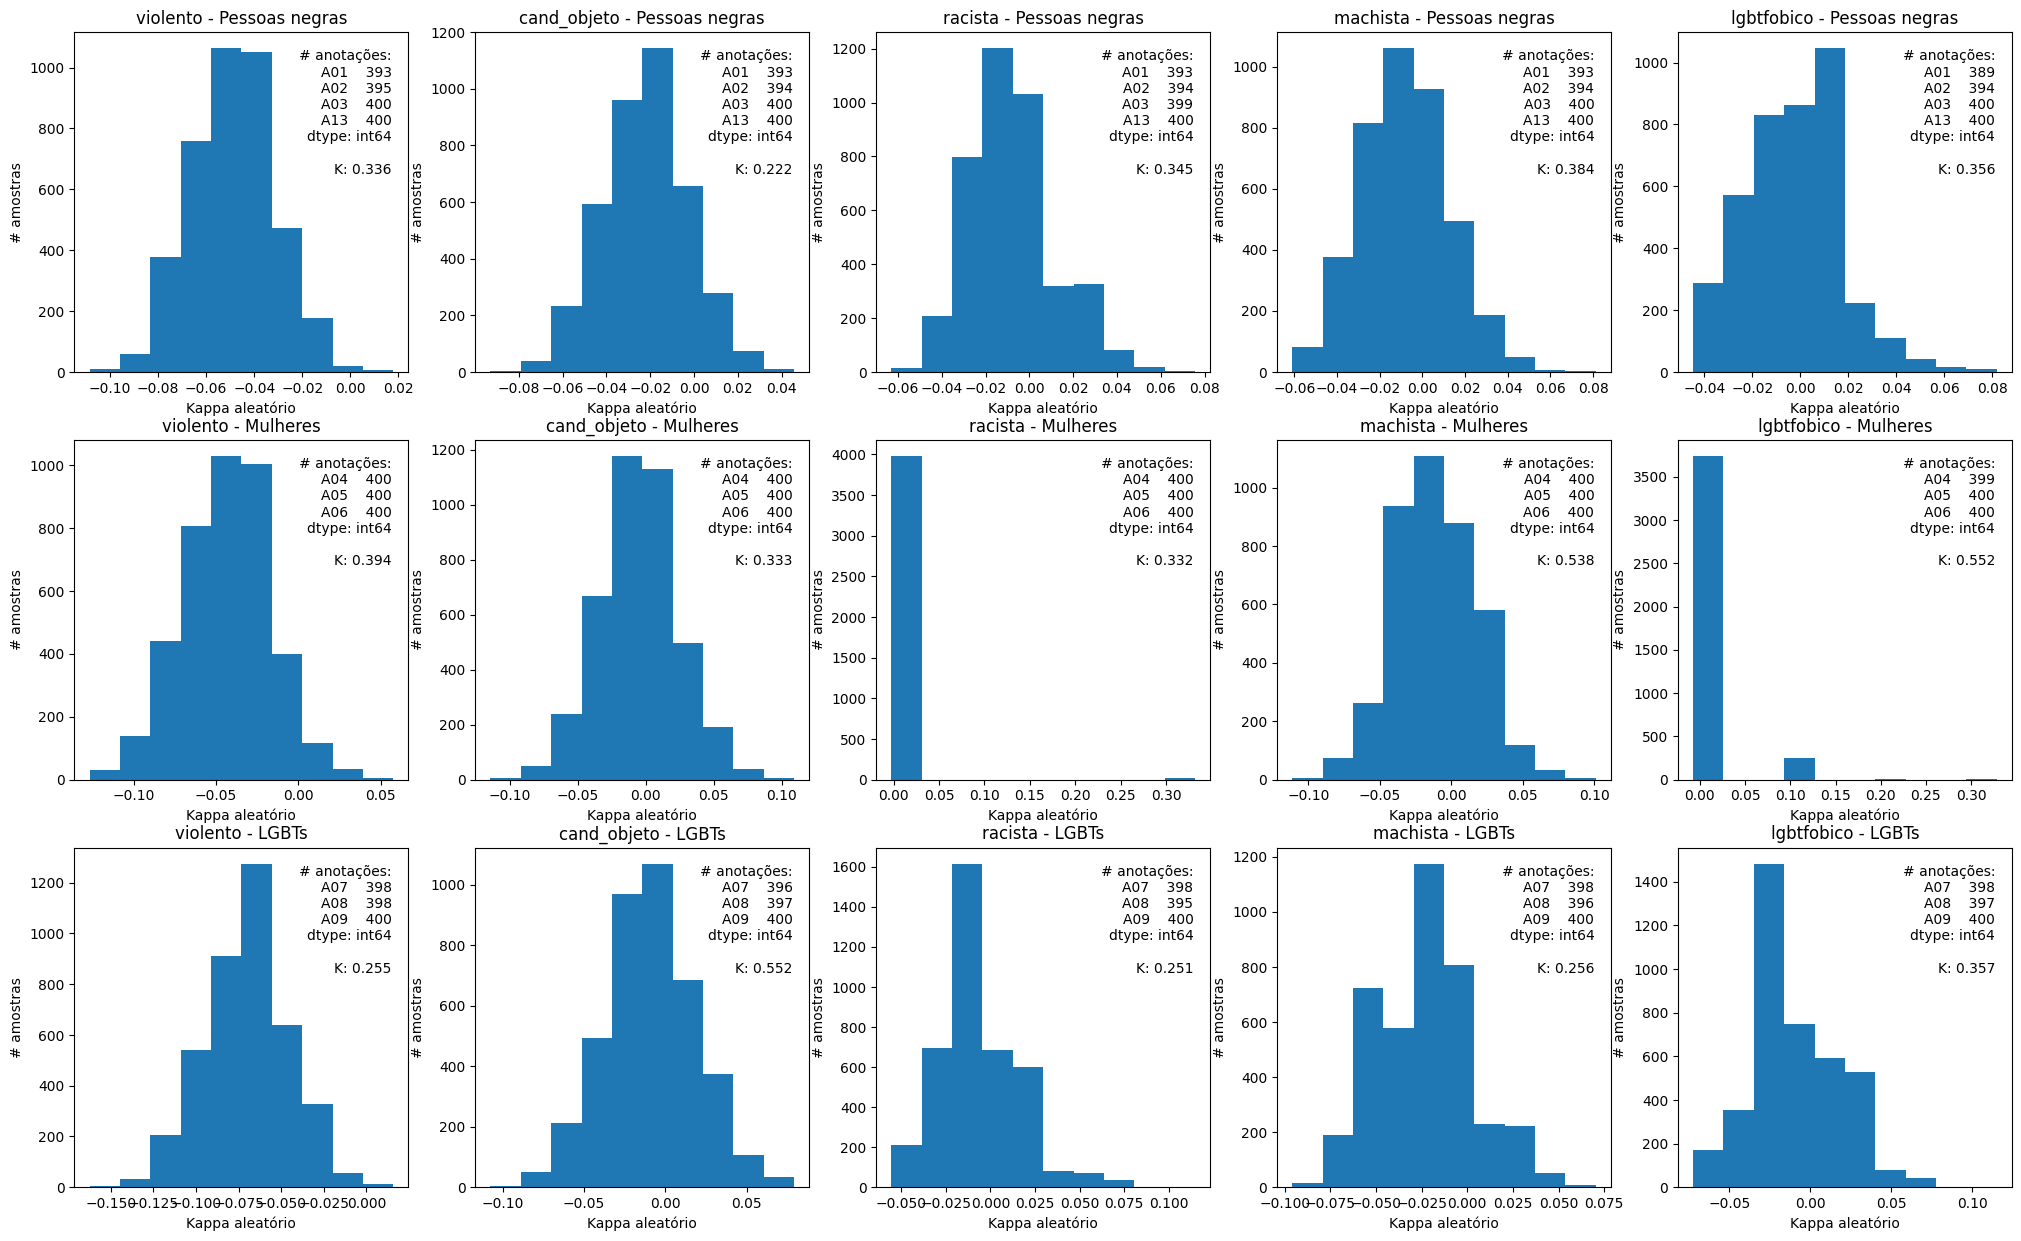

In [10]:
grupos = ['Pessoas negras', 'Mulheres', 'LGBTs']
campos = ['violento', 'cand_objeto', 'racista', 'machista', 'lgbtfobico']

n_campos = len(campos)
n_grupos = len(grupos)
pl.figure(figsize=(5 * n_campos, 5 * n_grupos))
for i, grupo in enumerate(grupos):
    for j, campo in enumerate(campos):
        pl.subplot(n_grupos, n_campos, 1 + j + i * n_campos)
        plot_agreement_report(dir_df, tweets_annotated_df, grupo, campo)


### Matriz de concord√¢ncia

In [256]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Sepeciona anota√ß√µes de interesse:
annotations_df = tweets_annotated_df[af.find_cols(tweets_annotated_df, 'violento_A')].drop(['violento_A10', 'violento_A11', 'violento_A12'], axis=1).dropna(how='all')
# Renomeia anotadores igual ao artigo:
paper_names    = annotations_df.columns.str.split('_').str.slice(-1).str.join('').map(xu.translate_dict({'A13':'A10', 'A06':'A10', 'A09':'A10'}))

def annotation_matrix_show(df, cmap, label, vmin=None):
    
    pl.matshow(df, cmap=cmap, vmin=vmin)
    pl.xticks(ticks=range(len(paper_names)), labels=paper_names)
    pl.yticks(ticks=range(len(paper_names)), labels=paper_names)
    pl.axvline(3.5, color='k')
    pl.axvline(6.5, color='k')
    pl.axhline(3.5, color='k')
    pl.axhline(6.5, color='k')
    ax = pl.gca()
    pl.tick_params(labelsize=10)
    pl.xlabel('    Pessoas negras        Mulheres            LGBTs', loc='left')
    ax.xaxis.set_label_position('top')
    pl.ylabel('        LGBTs           Mulheres        Pessoas negras', loc='bottom')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = pl.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel(label, fontsize=11)

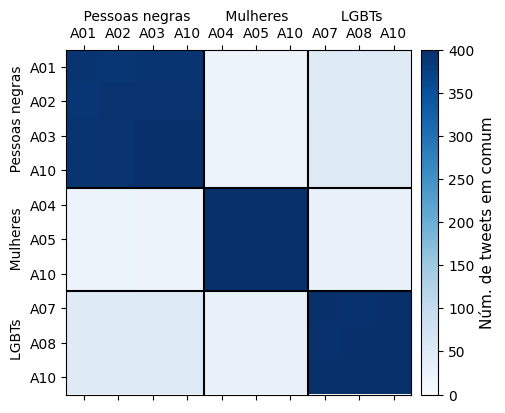

In [259]:
# N√∫mero de tweets anotados em comum:
exist_df = (~annotations_df.isnull()).astype(int)
common_anot_df = pd.DataFrame()
for c1 in exist_df.columns:
    for c2 in exist_df.columns:
        common_anot_df.loc[c1, c2] = (exist_df[c1] * exist_df[c2]).sum()

annotation_matrix_show(common_anot_df, 'Blues', 'N√∫m. de tweets em comum', vmin=0)

#pl.savefig('../resultados/plots/anotadores_matriz_n-comum.eps', bbox_inches='tight')
#pl.savefig('../resultados/plots/anotadores_matriz_n-comum.png', bbox_inches='tight')
pl.show()

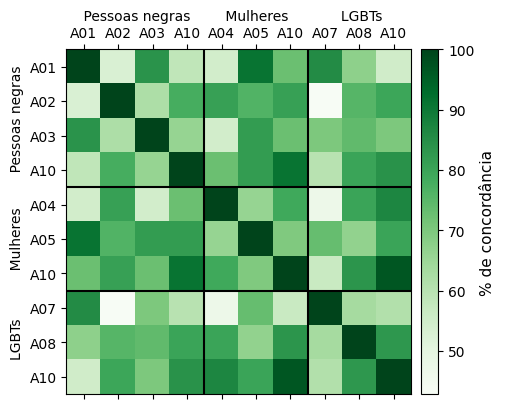

In [281]:
# Fra√ß√£o de anota√ß√µes iguais:
acc_df = pd.DataFrame()
for c1 in annotations_df.columns:
    for c2 in annotations_df.columns:
        pair_df = annotations_df[[c1, c2]].dropna(how='any')
        acc_df.loc[c1, c2] = accuracy_score(pair_df[c1], pair_df[c2])
        #acc_df.loc[c1, c2] = xs.fleiss_kappa(pair_df.astype(int).values, N_classes=2, n_votes_per_class=False)

#for c1 in acc_df.columns:
#    acc_df.loc[c1, c1] = np.NaN

#acc_df.where(common_anot_df > 100, np.NaN, inplace=True)

annotation_matrix_show(acc_df * 100, 'Greens', '% de concord√¢ncia')

#pl.savefig('../resultados/plots/anotadores_matriz_concordancia_block-diag.eps', bbox_inches='tight')
#pl.savefig('../resultados/plots/anotadores_matriz_concordancia_block-diag.png', bbox_inches='tight')
pl.show()

In [283]:
acc_df * 100

violento_A01  violento_A02  violento_A03  violento_A13  \
violento_A01    100.000000     52.820513     83.715013     58.269720   
violento_A02     52.820513    100.000000     62.025316     77.721519   
violento_A03     83.715013     62.025316    100.000000     66.000000   
violento_A13     58.269720     77.721519     66.000000    100.000000   
violento_A04     54.545455     80.952381     54.545455     72.727273   
violento_A05     90.909091     76.190476     81.818182     81.818182   
violento_A06     72.727273     80.952381     72.727273     90.909091   
violento_A07     85.714286     42.857143     70.000000     60.000000   
violento_A08     67.346939     75.510204     74.000000     80.000000   
violento_A09     55.102041     79.591837     70.000000     84.000000   

              violento_A04  violento_A05  violento_A06  violento_A07  \
violento_A01     54.545455     90.909091     72.727273     85.714286   
violento_A02     80.952381     76.190476     80.952381     42.857143   
violento_A03     54.545455     81.818182     72.727273     70.000000   
violento_A13     72.727273     81.818182     90.909091     60.000000   
violento_A04    100.000000     66.000000     79.000000     46.666667   
violento_A05     66.000000    100.000000     69.500000     73.333333   
violento_A06     79.000000     69.500000    100.000000     56.666667   
violento_A07     46.666667     73.333333     56.666667    100.000000   
violento_A08     80.000000     66.666667     83.333333     63.383838   
violento_A09     86.666667     80.000000     96.666667     61.055276   

              violento_A08  violento_A09  
violento_A01     67.346939     55.102041  
violento_A02     75.510204     79.591837  
violento_A03     74.000000     70.000000  
violento_A13     80.000000     84.000000  
violento_A04     80.000000     86.666667  
violento_A05     66.666667     80.000000  
violento_A06     83.333333     96.666667  
violento_A07     63.383838     61.055276  
violento_A08    100.000000     82.914573  
violento_A09     82.914573    100.000000

In [217]:
# % de concord√¢ncia esperada no chute (aprox.):
ratings = tweets_annotated_df.query('controle == 0')['violento_final'].dropna()
accuracy_score(ratings, xs.shuffle_data(ratings))

0.4972875226039783

In [263]:
common_anot_df

violento_A01  violento_A02  violento_A03  violento_A13  \
violento_A01         393.0         390.0         393.0         393.0   
violento_A02         390.0         395.0         395.0         395.0   
violento_A03         393.0         395.0         400.0         400.0   
violento_A13         393.0         395.0         400.0         400.0   
violento_A04          22.0          21.0          22.0          22.0   
violento_A05          22.0          21.0          22.0          22.0   
violento_A06          22.0          21.0          22.0          22.0   
violento_A07          49.0          49.0          50.0          50.0   
violento_A08          49.0          49.0          50.0          50.0   
violento_A09          49.0          49.0          50.0          50.0   

              violento_A04  violento_A05  violento_A06  violento_A07  \
violento_A01          22.0          22.0          22.0          49.0   
violento_A02          21.0          21.0          21.0          49.0   
violento_A03          22.0          22.0          22.0          50.0   
violento_A13          22.0          22.0          22.0          50.0   
violento_A04         400.0         400.0         400.0          30.0   
violento_A05         400.0         400.0         400.0          30.0   
violento_A06         400.0         400.0         400.0          30.0   
violento_A07          30.0          30.0          30.0         398.0   
violento_A08          30.0          30.0          30.0         396.0   
violento_A09          30.0          30.0          30.0         398.0   

              violento_A08  violento_A09  
violento_A01          49.0          49.0  
violento_A02          49.0          49.0  
violento_A03          50.0          50.0  
violento_A13          50.0          50.0  
violento_A04          30.0          30.0  
violento_A05          30.0          30.0  
violento_A06          30.0          30.0  
violento_A07         396.0         398.0  
violento_A08         398.0         398.0  
violento_A09         398.0         400.0

In [322]:
# Exportando exemplos de tweets anotados por todos:
fully_annotated_df = tweets_annotated_df.loc[tweets_annotated_df['n_violento'] >= 9]
n_violent = fully_annotated_df[af.find_cols(tweets_annotated_df, 'violento_A')].drop(['violento_A06', 'violento_A09'], axis=1).sum(axis=1)
n_violent.name = 'n_concorda'
#fully_annotated_df[['text', 'hate_score']].join(n_violent, how='inner').sort_values('n_concorda').to_csv('../resultados/tweets_completamente-anotados_violencia.csv', index=False)

### Rela√ß√£o com anotador controle

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
def show_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    
    cols = [campo + '_' + a1, campo + '_' + a2]
    data_df = tweets_df.loc[~tweets_df[cols].isnull().any(axis=1), cols]
    X = confusion_matrix(data_df[cols[0]], data_df[cols[1]], normalize=normalize)
    if len(X) == 0:
        X = np.array([[np.NaN, np.NaN], [np.NaN, np.NaN]])
    cm_df = pd.DataFrame(data=X, index=[a1 + ': N√£o', a1 + ': Sim'], columns=[a2 + ': N√£o', a2 + ': Sim'])
    cm_df.style.set_caption(campo)
    return cm_df

def std_confusion_matrix(tweets_df, campo, a1, a2, normalize=None):
    return show_confusion_matrix(tweets_df, campo, a1, a2, normalize=normalize).set_index(np.array(['Controle: N√£o', 'Controle: Sim']))

In [13]:
controle = dir_df.query('Respons√°vel == "Xavier"').set_index('Grupo')['Anotador']
controle.name = 'Controle'
anotadores_pairs_df = dir_df.query('Respons√°vel != "Xavier"').set_index('Grupo')[['Anotador']].join(controle)

In [36]:
campo = 'violento'
sigma_list = []
for campo in campos:
    print(xd.bold(campo))
    cm_dfs = []
    for grupo in grupos:
        sel_pair_df = anotadores_pairs_df.query('Grupo == "{}"'.format(grupo))
        for a1, a2 in zip(sel_pair_df['Controle'], sel_pair_df['Anotador']):
            cm = std_confusion_matrix(tweets_annotated_df, campo, a1, a2, normalize='all')
            cm_dfs.append(cm)
            
            anotador = cm.columns[0].split(':')[0]
            n_sigma  = (cm.iloc[0,1] - cm.iloc[1,0]) / np.sqrt(cm.iloc[0,1] + cm.iloc[1,0])
            sigma_list.append({'campo': campo, 'anotador': anotador, 'n_sigma':n_sigma})

    confusion_df = pd.concat(cm_dfs, axis=1)
    display(confusion_df)

violento


A01: N√£o  A01: Sim  A02: N√£o  A02: Sim  A03: N√£o  A03: Sim  \
Controle: N√£o  0.254453  0.407125  0.579747  0.083544    0.3475    0.3150   
Controle: Sim  0.010178  0.328244  0.139241  0.197468    0.0250    0.3125   

               A04: N√£o  A04: Sim  A05: N√£o  A05: Sim  A07: N√£o  A07: Sim  \
Controle: N√£o    0.6175    0.0925    0.4125    0.2975  0.462312  0.384422   
Controle: Sim    0.1175    0.1725    0.0075    0.2825  0.005025  0.148241   

               A08: N√£o  A08: Sim  
Controle: N√£o  0.741206  0.105528  
Controle: Sim  0.065327  0.087940

cand_objeto


A01: N√£o  A01: Sim  A02: N√£o  A02: Sim  A03: N√£o  A03: Sim  \
Controle: N√£o  0.066158  0.290076  0.276650  0.076142    0.2425    0.1175   
Controle: Sim  0.089059  0.554707  0.152284  0.494924    0.2425    0.3975   

               A04: N√£o  A04: Sim  A05: N√£o  A05: Sim  A07: N√£o  A07: Sim  \
Controle: N√£o    0.4300    0.0375    0.2675      0.20  0.373737  0.088384   
Controle: Sim    0.1575    0.3750    0.2225      0.31  0.111111  0.426768   

               A08: N√£o  A08: Sim  
Controle: N√£o  0.435768  0.027708  
Controle: Sim  0.183879  0.352645

racista


A01: N√£o  A01: Sim  A02: N√£o  A02: Sim  A03: N√£o  A03: Sim  \
Controle: N√£o  0.928753  0.050891  0.946701  0.032995  0.887218  0.092732   
Controle: Sim  0.007634  0.012723  0.015228  0.005076  0.002506  0.017544   

               A04: N√£o  A04: Sim  A05: N√£o  A05: Sim  A07: N√£o  A07: Sim  \
Controle: N√£o     0.995    0.0025    0.9975       0.0  0.904523  0.080402   
Controle: Sim     0.000    0.0025    0.0025       0.0  0.005025  0.010050   

               A08: N√£o  A08: Sim  
Controle: N√£o  0.939241  0.045570  
Controle: Sim  0.010127  0.005063

machista


A01: N√£o  A01: Sim  A02: N√£o  A02: Sim  A03: N√£o  A03: Sim  \
Controle: N√£o  0.865140  0.083969  0.913706  0.035533    0.8200    0.1300   
Controle: Sim  0.017812  0.033079  0.015228  0.035533    0.0075    0.0425   

               A04: N√£o  A04: Sim  A05: N√£o  A05: Sim  A07: N√£o  A07: Sim  \
Controle: N√£o    0.8375    0.0475    0.7375    0.1475  0.826633  0.155779   
Controle: Sim    0.0300    0.0850    0.0175    0.0975  0.002513  0.015075   

               A08: N√£o  A08: Sim  
Controle: N√£o  0.898990  0.083333  
Controle: Sim  0.005051  0.012626

lgbtfobico


A01: N√£o  A01: Sim  A02: N√£o  A02: Sim  A03: N√£o  A03: Sim  \
Controle: N√£o  0.928021  0.048843  0.956853  0.020305    0.9425    0.0325   
Controle: Sim  0.005141  0.017995  0.007614  0.015228    0.0150    0.0100   

               A04: N√£o  A04: Sim  A05: N√£o  A05: Sim  A07: N√£o  A07: Sim  \
Controle: N√£o  0.987469  0.002506    0.9850    0.0025  0.886935  0.090452   
Controle: Sim  0.007519  0.002506    0.0075    0.0050  0.000000  0.022613   

               A08: N√£o  A08: Sim  
Controle: N√£o  0.929471  0.047859  
Controle: Sim  0.005038  0.017632

In [18]:
sigma_df = pd.DataFrame(sigma_list)
sigma_df['abs_n_sigma'] = np.abs(sigma_df['n_sigma'])
sigma_df = sigma_df.sort_values('abs_n_sigma', ascending=False)
sigma_df.query('abs_n_sigma >= 0 and campo == "violento"')

campo anotador   n_sigma  abs_n_sigma
0  violento      A01  0.614478     0.614478
5  violento      A07  0.607952     0.607952
4  violento      A05  0.525107     0.525107
2  violento      A03  0.497346     0.497346
1  violento      A02 -0.118000     0.118000
6  violento      A08  0.097258     0.097258
3  violento      A04 -0.054554     0.054554

In [28]:
campo = 'racista'
anotador = 'A01'
row = anotadores_pairs_df.query('Anotador == "{}"'.format(anotador)).iloc[0]
print(row)
query0 = '({0}_{1} == 1 and {0}_{2} == 0)'
query1 = '({0}_{1} == 0 and {0}_{2} == 1)'
sel0 = tweets_annotated_df.query(query0.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Anotador n√£o marcou ({})'.format(len(sel0))))
xd.print_string_series(sel0.sample(min(10, len(sel0))))
sel1 = tweets_annotated_df.query(query1.format(campo, row['Controle'], row['Anotador'])).set_index('tweet_url')['text']
print(xd.bold('Controle n√£o marcou ({})'.format(len(sel1))))
xd.print_string_series(sel1.sample(min(10, len(sel1))))

Anotador    A01
Controle    A13
Name: Pessoas negras, dtype: object
Anotador n√£o marcou (3)
https://www.twitter.com/Bruno__Rogers/status/1573345741719879680: @danimontpsol O povo estava com toda raz√£o. Lixo deve ser jogado fora mesmo. Sem pena. 

O RJ √© 100% bolsonarista merm√£o. Quem n√£o aceita isso √© esquerdista fracassado.
https://www.twitter.com/xarope_bolado/status/1567979648956481538: @beatrizcaminha Por isso que me d√° uma raiva tremenda quando algu√©m vem com esse papo de "ah,exterm√≠nio da popula√ß√£o negra",mimimi...me poupe!!!!Eu sou NEG√ÉO,p...,n√£o coitadinho,nem vitiminha,nem escravinho!!!!Ah,e GOD SAVE THE QUEEN!!!!REST IN PEACE!!!!!!!!!!
https://www.twitter.com/Jed_KapIan/status/1574472401269788680: @renatasouzario Kkkkk vai l√° defensora dos traficantes fracos e oprimidos
Controle n√£o marcou (20)
https://www.twitter.com/Hellephant2/status/1568215733213036545: @southaferreira Mimimi racismo imperialismo, enquanto isso faz parte de um partido comunista, ideologia r

#### Anota√ß√µes sobre viol√™ncias espec√≠ficas

In [22]:
test_df = tweets_annotated_df.query('controle == 0')
for v in ['racista_final', 'machista_final', 'lgbtfobico_final']:
    print(v, test_df[v].sum())

racista_final 26.0
machista_final 99.0
lgbtfobico_final 31.0


### Exemplos de viol√™ncias espec√≠ficas

In [158]:
n_check = tweets_annotated_df.loc[:, ['lgbtfobico_A07', 'lgbtfobico_A08', 'lgbtfobico_A09']].dropna().sum(axis=1)
n_check.name = 'n_lgbtfobico'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_lgbtfobico').sample(2, random_state=57)
#togo.to_csv('../resultados/tweets-anotados3_lgbtfobia.csv')

In [156]:
n_check = tweets_annotated_df.loc[:, ['machista_A04', 'machista_A05', 'machista_A05']].dropna().sum(axis=1)
n_check.name = 'n_machista'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_machista').sample(2, random_state=57)
#togo.to_csv('../resultados/tweets-anotados3_machismo.csv')

In [14]:
n_check = tweets_annotated_df.loc[:, ['racista_A01', 'racista_A02', 'racista_A03', 'racista_A13']].dropna().sum(axis=1)
n_check.name = 'n_racista'
sel = tweets_annotated_df[['text', 'tweet_url']].join(n_check, how='inner')
togo = sel.groupby('n_racista').sample(2, random_state=57)
#togo.to_csv('../resultados/tweets-anotados4_racismo.csv')

In [23]:
togo.loc[1062]['tweet_url']

'https://www.twitter.com/Josipadilha3/status/1572367871912865793'

In [25]:
tweets_annotated_df.loc[tweets_annotated_df['text'].str.contains('Que absurdo! Que sujeito bo√ßal!')]['violento_final']

1096    0.0
Name: violento_final, dtype: float64

In [163]:
tweets_annotated_df.loc[412][['cand_objeto_A07', 'cand_objeto_A08', 'cand_objeto_A09']]

cand_objeto_A07    NaN
cand_objeto_A08    1.0
cand_objeto_A09    0.0
Name: 412, dtype: object

In [159]:
xd.print_string_series(togo.set_index('tweet_url')['text'])

https://www.twitter.com/santajoyb/status/1575202675586498560: Vov√≥ sem deputado estadual e eu ‚Äúvamo de Vini‚Äù a√≠ ela ‚Äúsei n√£o, nunca vi aqui na ilha‚Äù a√≠ eu ‚Äúele t√° com Lula‚Äù ela ‚Äút√°, vou pensar‚Äù 
A realidade √© que ngm lembra da Ilha do Maruim mesmo, hey @castelllovini bora mudar isso a√≠
https://www.twitter.com/dani88azevedo/status/1575915534415106049: @mariamarighella @jairmearrependi @lucinhadomst Minhas deputadas ‚ù§Ô∏è
https://www.twitter.com/PauloFarias2000/status/1564370973989666817: @ErikakHilton @ManuelaDavila S√≥ as feias como vc.
https://www.twitter.com/AntiPTantiBozo/status/1571613262306746375: @fabiofelixdf Mamador do dinheiro publico!!! Fuj√£o, covarde!
https://www.twitter.com/Leandro45100/status/1572038089110917121: @ErikakHilton Gostaria saber quantos idiota voto ser desse
https://www.twitter.com/andremaronga1/status/1564063427332657154: @fabiofelixdf T√° querendo falar grosso !! Kkkk mas t√° mais perdida que tudo !!
https://www.twitter.com/DimPatri

### Impacto do objeto na anota√ß√£o

In [40]:
# Separando tweets por objeto:
test_df      = tweets_annotated_df.query('controle == 0')
terceiros_df = test_df.query('cand_objeto_final == 0')
direto_df    = test_df.query('cand_objeto_final == 1')

In [94]:
# Buscando palavras comuns:
xd.print_string_series(test_df.query('violento_final == 1 and cand_objeto_final == 0')['text'].sample(10))

866: @Biakicis Vagabundo
1308: @perpetua_acre Bando de ‚Äúartistas‚Äù i interesseiros
790: @majorfabianadep Mais uma babaquice fake News feia do jornalismo lun√°tico esquerdopata louco de plant√£o
42: @matheuspggomes Bolsonaristas s√£o est√∫pidos e burros por natureza. Lula ser√° eleito. Bolsonazi vai pra cadeia pagar pelos crimes cometidos. E os bolsominios,  cambada est√∫pida e naturalmente burra, voltar√£o para os esgotos fedorentos de onde sa√≠ram. Vai um choror√¥ s√≥.
924: @jessicamichels Minha hip√≥tese √© makumba. As regi√µes com mais aglomera√ß√£o de makumbeiro t√£o cheia de pombo.
639: @fabiofelixdf Banda de merda !
734: @majorfabianadep Isto √© vagabundagem deste malandro
1353: @apropriajulia Eu vou com camiseta amarela votar e fod@se o cabe√ßa de piroc@
1428: @majorfabianadep @RomarioOnze S√≥  um drogado !!!
1489: @pastorhenriquev L de LEGI√ÉO https://t.co/0mrYBEYfQp


In [112]:
# Sele√ß√£o por palavras comuns e contabiliza√ß√£o por viol√™ncia ou n√£o:
regexes = [r'v[a4@]g[a4@]bund', r's[a4@]f[a4@]d', r'\b(?:bosta|merda)\b', r'r[1i]d[1i√≠][kc]ul[a@o]', r'nojent', r'\bnojo\b', r'ladr[√£a@]o', r'ment[1i]ros[ao]', 
           r'\b[ck](?:u|ool?)\b', r'canalha', r'bandid[ao]', r'\bburr[ao]|besta\b', r'piranha', r'carni√ßa', r'lixo', r'p[@4a]lh[@4a][c√ß][a40@o]\b', r'm[@4a]l[@4a]ndr[ao40@]', r'est[u√∫]pid[oa]']
regexes = [r'v[a4@]g[a4@]bund']
norm = False
sel_direto    = direto_df.loc[direto_df['text'].str.contains('|'.join(regexes), case=False)]
sel_terceiros = terceiros_df.loc[terceiros_df['text'].str.contains('|'.join(regexes), case=False)]
print(xd.bold('Candidatura'))
print(sel_direto['violento_final'].value_counts(normalize=norm).sort_index())
print(xd.bold('Terceiros'))
print(sel_terceiros['violento_final'].value_counts(normalize=norm).sort_index())

Candidatura
0.0     2
1.0    20
Name: violento_final, dtype: int64
Terceiros
0.0     4
1.0    13
Name: violento_final, dtype: int64


In [113]:
print(xd.bold('Candidatura'))
print(sel_direto['hate_score'].mean())
print(xd.bold('Terceiros'))
print(sel_terceiros['hate_score'].mean())

Candidatura
0.6919999413636363
Terceiros
0.7059351764705883


In [114]:
# Exemplos:
print(xd.bold('Candidatura'))
xd.print_string_series(sel_direto.set_index('violento_final')['text'].sample(10))
print(xd.bold('Terceiros'))
xd.print_string_series(sel_terceiros.set_index('violento_final')['text'].sample(10))

Candidatura
1.0: @guimaraes13PT @ricardostuckert Esse vagabundo s√≥ quer nosso dinheiro.
1.0: @samiabomfim Aborto √© ASSASSINATO sua vagabunda
0.0: @FernandoHoliday Concordo e votar no Bolsonaro √© dar carta branca ao NEGACIONISTA maldito que empurrou milhares pra morte e ainda ZOMBOU! Vagabundo!!!
1.0: @tiriricanaweb Vai pra casa, vagabundo.
1.0: @Eunicio √â muito desgra√ßado esse vagabundo. https://t.co/I5Vcj9vwlL
1.0: @depheliolopes Al√©m de ladr√£o  ,Vagabundo  ,mentiroso √©  invejoso nunca si importou com 7 setembro  e com nossa  bandeira muito menos com brasileiros
1.0: @depheliolopes H√©li√£o, precisa bater firme nesse vagabundo! Ele ofendeu a todos brasileiros que foram comemorar nossa independ√™ncia.
1.0: @samanthacavalca E quem √© vc realmente,uma pessoa odiosa, miser√°vel d√©bil metal piscopata inverterada,mil√≠ciana imb√©cil ot√°ria e apoiadora de um vagabundo mil√≠ciano desgracado negacionista genocida BOZOVIRUS dos quintos dos inferno,vai te pra pqp
1.0: @Eunicio Vai toma

## An√°lise

### Desempenho individual

In [15]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

In [16]:
# M√©tricas sobre os dados (que foram amostrados por hate_score):
test_df = tweets_annotated_df.query('controle == 0')
frac_violento = 0.164
# Metrics:
for name, scorer in {'acc': accuracy_score, 'f1': f1_score, 'prec': precision_score, 'rec': recall_score, 'ghr': ml.geomean_hit_rate}.items():
    s = scorer(test_df['violento_final'], test_df['hate_score'] > 0.5)
    print('{}: {:.3f}'.format(name, s))

acc: 0.712
f1: 0.644
prec: 0.639
rec: 0.649
ghr: 0.699


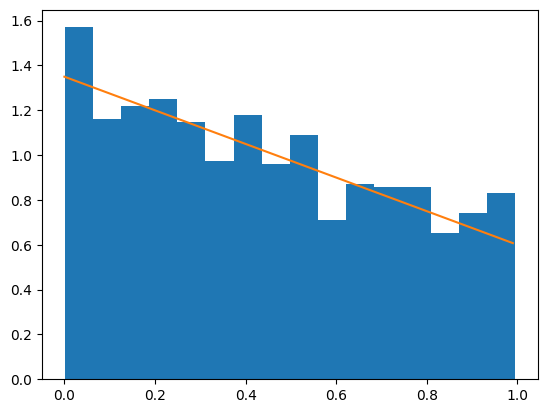

In [14]:
# Estimativa de precision e recall a partir dos fits da densidade de dados e fra√ß√£o de positivos:

def rho(score):
    # Fit linear da densidade feito no olho:
    return 1.35 - 0.75 * score

def f(score):
    # Fit linear da fra√ß√£o, valores retornados pela fun√ß√£o af.plot_tweets_correspondence abaixo:
    return 0.07 + 0.758 * score

thres = np.arange(0, 1, 0.01)
prec = af.f_to_precision(thres, rho(thres), f(thres))
rec  = af.f_to_recall(thres, rho(thres), f(thres))

pl.hist(test_df['hate_score'], bins=16, density=True)
pl.plot(thres, rho(thres))
pl.show()

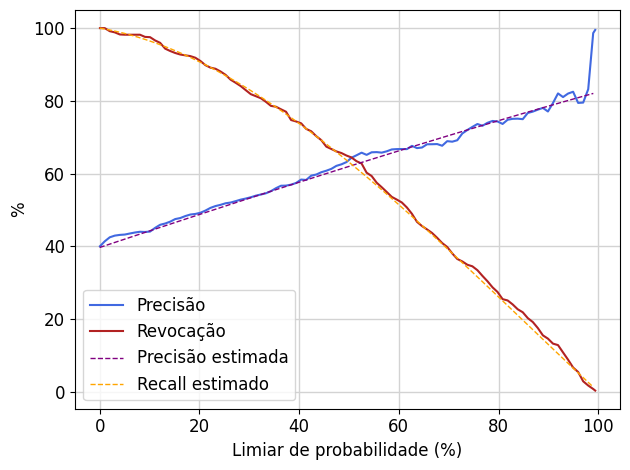

In [15]:
precision, recall, threshold = [], [], []
x = np.linspace(0, 1, 100)
for n in range(200):
    sample_df = af.sample_fixed_proportion(test_df, 'violento_final', 0.40)
    p, r, t = precision_recall_curve(sample_df['violento_final'], sample_df['hate_score'])
    precision.append(np.interp(x, t, p[:-1]))
    recall.append(np.interp(x, t, r[:-1]))
    threshold.append(np.interp(x, t, t))

threshold = np.array(threshold).mean(axis=0)
precision = np.array(precision).mean(axis=0)
recall    = np.array(recall).mean(axis=0)

pl.plot(threshold * 100, precision * 100, label='Precis√£o', color='royalblue')
pl.plot(threshold * 100, recall * 100, label='Revoca√ß√£o', color='firebrick')
pl.xlabel('Limiar de probabilidade (%)', fontsize=12)
pl.ylabel('%', fontsize=12)
pl.tick_params(labelsize=12)
pl.grid(linewidth=1, color='lightgray')
pl.tight_layout()
#pl.savefig('../resultados/plots/precision-recall-curve_aplicacao-11pc.eps')
#pl.savefig('../resultados/plots/precision-recall-curve_aplicacao-11pc.png')

pl.plot(thres * 100, prec * 100, color='purple', linestyle='--', linewidth=1, label='Precis√£o estimada')
pl.plot(thres * 100, rec * 100, color='orange', linestyle='--', linewidth=1, label='Recall estimado')

pl.legend(fontsize=12)

pl.show()

In [16]:
orig_density_df = pd.read_csv('../dados/processados/dens_eletweets100+_por_score.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


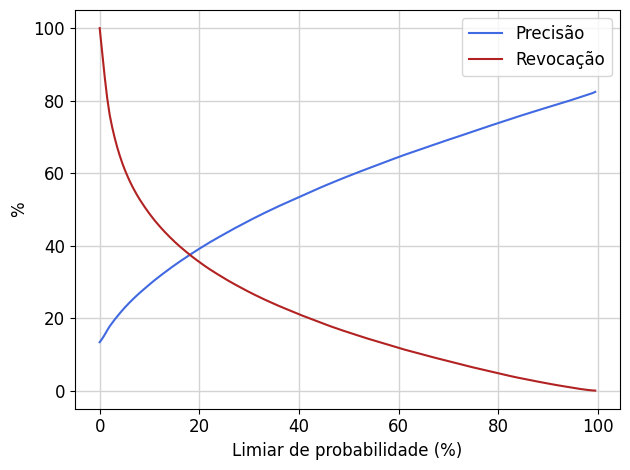

In [18]:
x = orig_density_df['hate_score'].values
precision_est = af.f_to_precision(x, orig_density_df['tweet_density'].values, f(x))
recall_est    = af.f_to_recall(x, orig_density_df['tweet_density'].values, f(x))

pl.plot(x * 100, precision_est * 100, color='royalblue', label='Precis√£o')
pl.plot(x * 100, recall_est * 100, color='firebrick', label='Revoca√ß√£o')
pl.legend(fontsize=12)
pl.xlabel('Limiar de probabilidade (%)', fontsize=12)
pl.ylabel('%', fontsize=12)
pl.tick_params(labelsize=12)
pl.grid(linewidth=1, color='lightgray')
pl.tight_layout()

#pl.savefig('../resultados/plots/prec-recall_estimada-producao.eps')
#pl.savefig('../resultados/plots/prec-recall_estimada-producao.png')

pl.show()

In [30]:
test_df['cand_objeto_final'].mean()

0.523508137432188

In [31]:
len(test_df)

1106

### Desempenho geral

In [17]:
# Fra√ß√£o estimada de tweets violentos:
test_df['hate_score'].mean()

0.4373715236757052

In [18]:
# Fra√ß√£o dos tweets que foram anotados como violentos:
test_df['violento_final'].mean()

0.4023508137432188

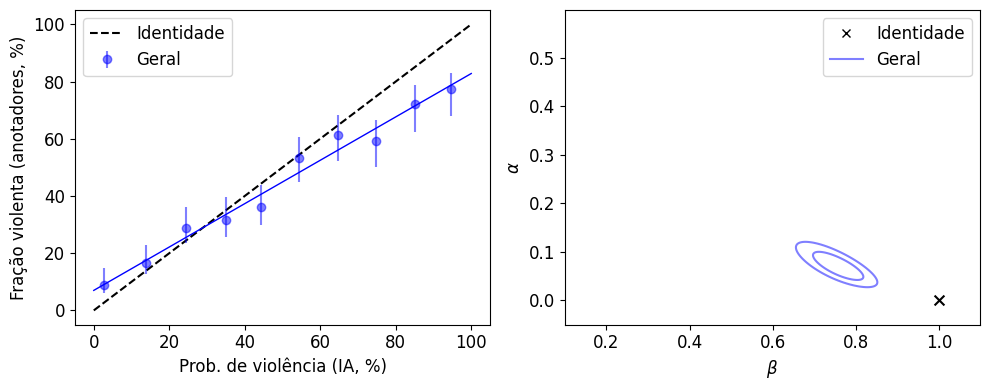

In [19]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

a, b = af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0'), 'Geral', 'b')
#a, b = af.plot_tweets_correspondence(af.sample_fixed_proportion(tweets_annotated_df.query('controle == 0'), 'violento_final', 0.60), 'Geral', 'b')

pl.subplot(1,2,1)
pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
pl.ylabel('Fra√ß√£o violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

contline = mlines.Line2D([], [], color='b', markersize=15, label='Geral', alpha=0.5)
cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
pl.legend(handles=[cross, contline], fontsize=12)

pl.tight_layout()

#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_geral.svg')
#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_geral.png')
pl.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


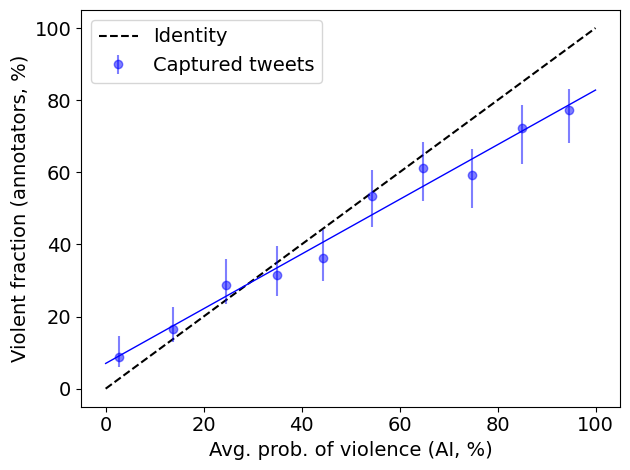

In [27]:
# Plot for paper in English:
stats_df = af.annotations_to_stats(tweets_annotated_df.query('controle == 0'))
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identity')
af.plot_score_correspondence(stats_df, a, b, 'Captured tweets', 'b')
pl.xlabel('Avg. prob. of violence (AI, %)', fontsize=14)
pl.ylabel('Violent fraction (annotators, %)', fontsize=14)
pl.legend(fontsize=14)
pl.tick_params(labelsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_geral_EN.eps')

In [28]:
b

0.758

### Desempenho vs. objeto do coment√°rio

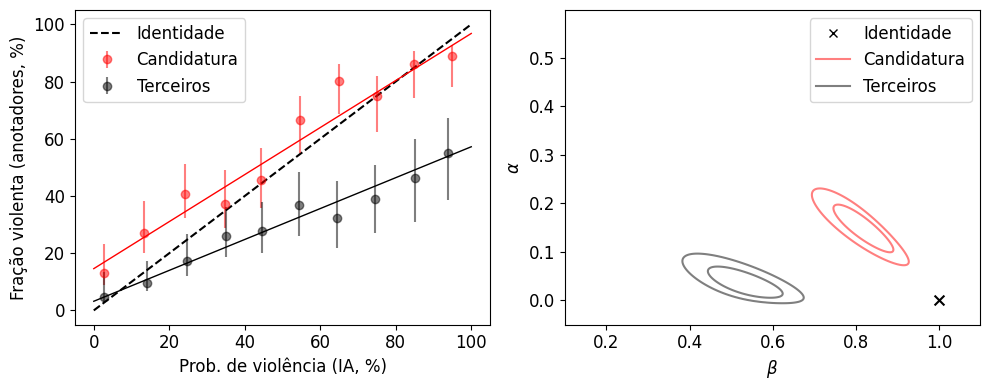

In [34]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 1 and controle == 0'), 'Candidatura', 'r')
af.plot_tweets_correspondence(tweets_annotated_df.query('cand_objeto_final == 0 and controle == 0'), 'Terceiros', 'k')

pl.subplot(1,2,1)
pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
pl.ylabel('Fra√ß√£o violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
contline1 = mlines.Line2D([], [], color='r', markersize=15, label='Candidatura', alpha=0.5)
contline2 = mlines.Line2D([], [], color='k', markersize=15, label='Terceiros', alpha=0.5)
pl.legend(handles=[cross, contline1, contline2], fontsize=12)

pl.tight_layout()

#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_objeto.svg')
#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_objeto.png')
pl.show()

### Diferentes grupos com um mesmo anotador

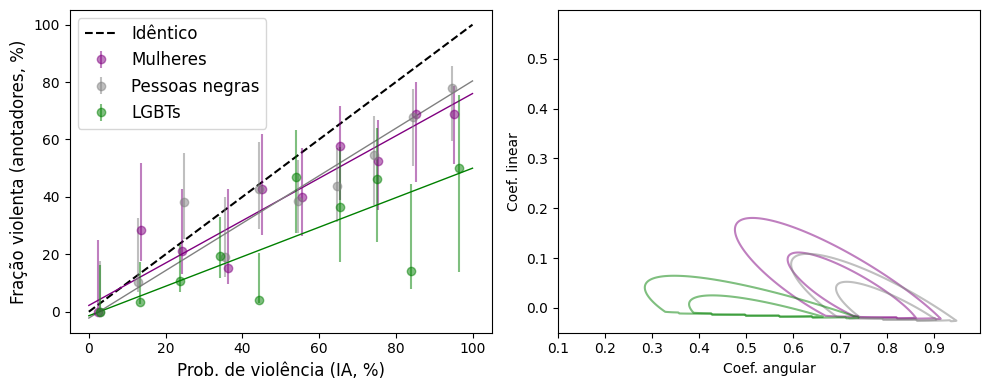

In [39]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Id√™ntico')

a = 'A06'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Mulheres', 'purple', final_suffix='_' + a)
a = 'A13'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'Pessoas negras', 'gray', final_suffix='_' + a)
a = 'A09'
af.plot_tweets_correspondence(tweets_annotated_df.loc[~tweets_annotated_df['violento_' + a].isnull() & (tweets_annotated_df['cand_objeto_final'] == 1)], 'LGBTs', 'green', final_suffix='_' + a)

pl.subplot(1,2,1)
pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
pl.ylabel('Fra√ß√£o violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)

pl.subplot(1,2,2)
pl.xlabel('Coef. angular')
pl.ylabel('Coef. linear')

pl.tight_layout()
pl.show()

### Cada grupo com 3 anotadores

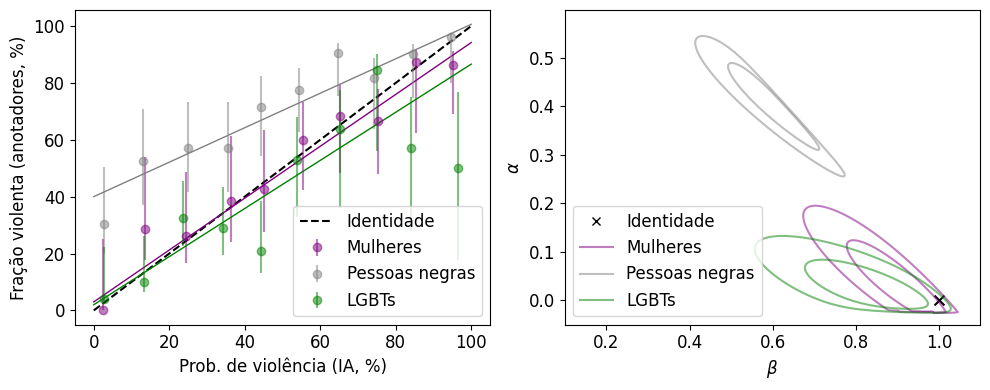

In [30]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('mulheres == 1 and cand_objeto_final == 1'), 'Mulheres', 'purple')
af.plot_tweets_correspondence(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1'), 'Pessoas negras', 'gray')
af.plot_tweets_correspondence(tweets_annotated_df.query('lgbts == 1 and cand_objeto_final == 1'), 'LGBTs', 'green')

pl.subplot(1,2,1)
pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
pl.ylabel('Fra√ß√£o violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
contline1 = mlines.Line2D([], [], color='purple', markersize=15, label='Mulheres', alpha=0.5)
contline2 = mlines.Line2D([], [], color='gray', markersize=15, label='Pessoas negras', alpha=0.5)
contline3 = mlines.Line2D([], [], color='green', markersize=15, label='LGBTs', alpha=0.5)
pl.legend(handles=[cross, contline1, contline2, contline3], fontsize=12, loc='lower left')

pl.tight_layout()

#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_grupo-social.svg')
#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_grupo-social.png')
pl.show()

In [23]:
# Tweets direcionado a candidaturas negras anotados como violentos e rankeados como n√£o violentos pela IA:
xd.print_string_series(tweets_annotated_df.query('pessoas_negras == 1 and cand_objeto_final == 1 and violento_final == 1 and hate_score < 0.2').set_index('tweet_url')['text'])

https://www.twitter.com/CillerTavares/status/1561346219045261315: @guimaraes13PT @ricardostuckert O Homem chamado capit√£o cueca  volta a atacar.
https://www.twitter.com/Carlinhosclube/status/1564253251998031873: @jfernandaBrasil T√° loka?
https://www.twitter.com/lukinha360games/status/1564440907755167744: @LeoSuricate A√≠ mente DEMAIS üòè
https://www.twitter.com/JosAlfredoDeTo1/status/1564625070550663168: @andremarianors KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
https://www.twitter.com/MarcioBraga01/status/1564802248118501378: @tiriricanaweb Volta p circo de onde veio.. o da pol√≠tica j√° tem palha√ßos demais!
https://www.twitter.com/Dansouza81/status/1564917677059080200: @Eunicio Falou o picareta da empresa Manchester que ganhou um contrato de 1 bilh√£o da Petrobr√°s sem Licita√ß√£o!!!!
https://www.twitter.com/rodrigokrfarias/status/1567679929168306178: @fabiofelixdf O Brasil teve um super√°vit nas contas p√∫blicas de R$19,3bi. Maior √≠ndice em 11 anos. E outra, infla√ß√£o boa √© a d

### Por tipo de viol√™ncia

In [35]:
tweets_annotated_df.query('controle == 0 and violento_final == 1')[['racista_final', 'machista_final', 'lgbtfobico_final']].sum()

racista_final       24.0
machista_final      97.0
lgbtfobico_final    26.0
dtype: float64

In [32]:
tweets_annotated_df.query('controle == 0 and violento_final == 1')[['racista_final', 'machista_final', 'lgbtfobico_final']].mean()

racista_final       0.053933
machista_final      0.217978
lgbtfobico_final    0.058427
dtype: float64

In [39]:
from scipy.stats import ks_2samp

In [83]:
def compare_scores_per_violence_type(tweets_df, campo, color=None):

    edges = np.arange(0, 101, 10)
    generic  = tweets_df.query('violento_final == 1 and racista_final == 0 and machista_final == 0 and lgbtfobico_final == 0' )['hate_score'] * 100
    specific = tweets_df.query(campo + '_final == 1 and violento_final == 1')['hate_score'] * 100
    ks = ks_2samp(generic, specific)

    ax = pl.gca()
    pl.text(0.02, 0.8, 'Valor-$p$ (KS): {:.1f}%'.format(ks.pvalue * 100), transform=ax.transAxes, ha='left', va='top', fontsize=12)
    xp.errorbar_hist(specific, bins=edges, alpha=0.4, color=color, density=True, label=campo.replace('_', ' ').capitalize(), rwidth=0.95)
    xp.errorbar_hist(generic, bins=edges, alpha=0.4, color='gray', density=True, label='Gen√©rico', rwidth=0.95)

    pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
    pl.legend(loc='upper left', fontsize=12)
    #pl.title('Nota da IA para coment√°rios violentos, por tipo')

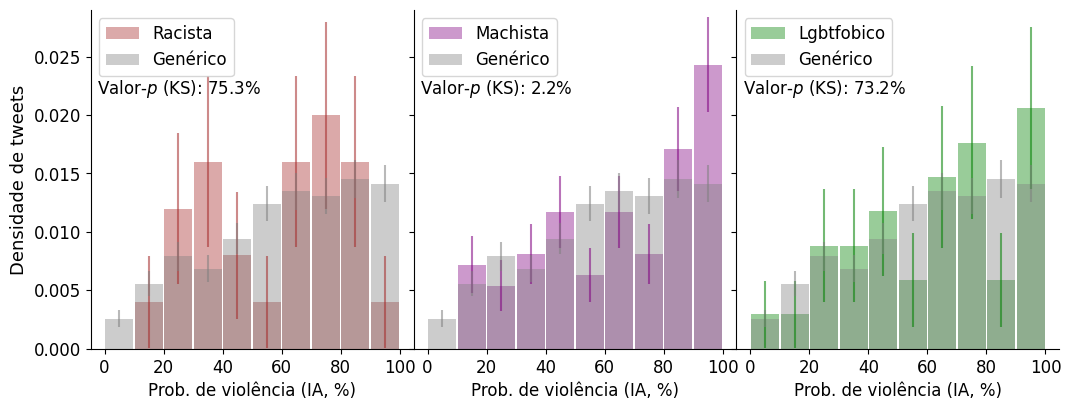

In [91]:
pl.figure(figsize=(12.5, 4.4))
for i, campo, cor in zip([1, 2, 3], ['racista', 'machista', 'lgbtfobico'], ['brown', 'purple', 'g']):
    pl.subplot(1, 3, i)
    compare_scores_per_violence_type(tweets_annotated_df, campo, cor)
    pl.ylim([0, 0.029])
    
    pl.tick_params(labelsize=12)
    ax = pl.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if i > 1:
        #pl.yticks([])
        #ax.spines['left'].set_visible(False)
        ax.axes.yaxis.set_ticklabels([])
    else:
        pl.ylabel('Densidade de tweets', fontsize=13)

pl.subplots_adjust(wspace=0)
#pl.savefig('../resultados/plots/hist_score-por-tipo.svg', bbox_inches='tight')
#pl.savefig('../resultados/plots/hist_score-por-tipo.png', bbox_inches='tight')
pl.show()

### Erros do modelo

In [69]:
newnames = {'text': 'Texto com r√≥tulo final de n√£o-violento', 'hate_score': 'Score'}
fp_df = tweets_annotated_df.query('controle == 0 and violento_final == 0').sort_values('hate_score').tail(10)[['text', 'hate_score']]
ids = pd.Series(np.arange(1, len(fp_df) + 1), dtype=int, name='ID')
fp_df = fp_df.rename(newnames, axis=1)#.set_index(ids, drop=True)
fp_df
#fp_df.to_csv('../resultados/erros_tweets_falsos-positivos.csv')

Texto com r√≥tulo final de n√£o-violento     Score
455       @CarinaBelome Esse povo √© safado at√© o ultimo  0.938491
299                             @Zambelli2210 Vagabundo  0.939317
372                      @ValeriaBnews Traidora nojenta  0.946588
1267  @caroldartora13 Covarde e bund√£o como todo bol...  0.948944
1410                    @ErikakHilton que gata da porra  0.960220
1491  @joicehasselmann Sai pra l√° sua oportunista tr...  0.965421
895                          @juujuferrari Gostosa juju  0.969009
1248                   @jandira_feghali Bandido! Safado  0.977099
744          @JulianaBrizola Ele virou chuchuca do bozo  0.979481
1216                           @CarolDeToni Toma safada  0.984331

In [67]:
newnames = {'text': 'Texto com r√≥tulo final de violento', 'hate_score': 'Score'}
fn_df = tweets_annotated_df.query('controle == 0 and violento_final == 1').sort_values('hate_score').head(10)[['text', 'hate_score']]
ids = pd.Series(np.arange(1, len(fn_df) + 1), dtype=int, name='ID')
fn_df = fn_df.rename(newnames, axis=1)#.set_index(ids, drop=True)
fn_df
#fn_df.to_csv('../resultados/erros_tweets_falsos-negativos.csv')

Texto com r√≥tulo final de violento     Score
1051  @marcosbrazrio Ganhamos o sorteio? Apaga isso ...  0.012704
1071  @AlanLopesRio √â @reinaldoazevedo @GugaNoblat @...  0.013490
1338        @AriadnaArantes @LulaOficial Quem √© esse???  0.015862
1489  @pastorhenriquev L de LEGI√ÉO https://t.co/0mrY...  0.019859
1034  @gabysantospdt @Sen_Cristovam Um eleitor lixo....  0.023702
498   @tiriricanaweb Volta p circo de onde veio.. o ...  0.030544
764   @fabiofelixdf O Brasil teve um super√°vit nas c...  0.031974
532   @orlandosilva N√©h... hipocrisia,  sabemos quem...  0.037796
1487  @vivireispsol Lacrolandia tu vai ser DEMITIDA ...  0.080925
823   @TandaraCaixeta Tu √© t√£o deplor√°vel que a Fabi...  0.087384

In [79]:
tweets_annotated_df.query('controle == 0')['violento_final'].mean()

0.4023508137432188

In [75]:
tweets_annotated_df.loc[895, 'tweet_url']

'https://www.twitter.com/Raimund97859836/status/1569744554630283264'

### Escala de viol√™ncia

In [13]:
test_df = tweets_annotated_df.query('controle == 0')
scale_df = test_df.groupby(af.bin_prob(test_df['hate_score'], 0.1)).sample(3).sort_values('hate_score')
xd.print_string_series(scale_df.set_index('hate_score')['text'])

0.004766899: @RobeyonceLima Boa tardeüåπüåπüåπ Amada, me indique 1 candidato a Dep. Estadual e um Senador???
Presidente, Governador e Dep. Federal (5000) eu j√° tenho.
üòòüòò
Obrigado!!
0.012264683: Meu compromisso com @bellagoncalvs pra deputada Estadual em seu voto? Tem algo errado a√≠‚Ä¶ü§î
0.03244818: @bellagoncalvs A mulher fez defesa do agroneg√≥cio, falou do MST, o combo completo e a cor do sapato √© o que importa?
0.14262912: @jfernandaBrasil T√° loka?
0.1630831: @renatasouzario Kkkkk vai l√° defensora dos traficantes fracos e oprimidos
0.18367282: @perpetua_acre Que tolice
0.20082115: @gabysantospdt Pra cima deles, Gabi.
0.20593633: @AriadnaArantes @LulaOficial kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk(estude)
0.2474989: @Izalourenca Zema sim
0.32397065: @danimontpsol Votar nessa corja de abutres, esquerda maldita nunca, n√£o vote nessa corja.
0.3360351: @bellagoncalvs S√≥ absurdo! Sabia que ele cancelou a agenda de um evento de cult

# Lixo

## Ajuste com viol√™ncias espec√≠ficas

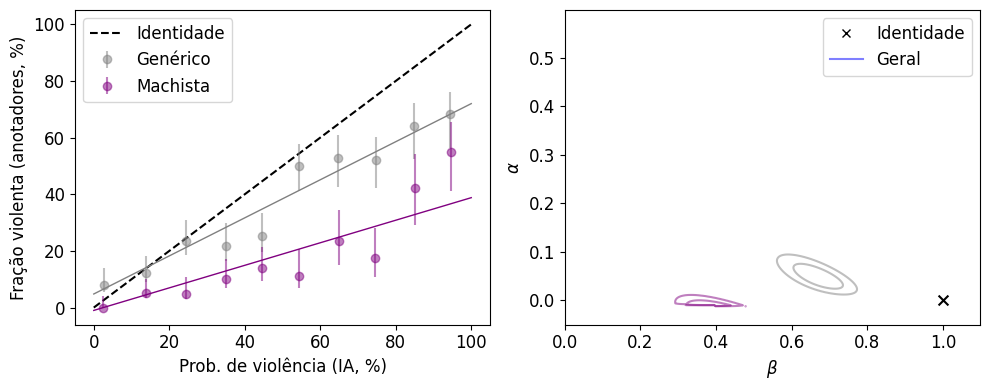

In [32]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
pl.plot([0,100], [0,100], linestyle='--', color='k', label='Identidade')

af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and racista_final == 0 and machista_final == 0 and lgbtfobico_final == 0'), 'Gen√©rico', 'gray')
af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or machista_final == 1)'), 'Machista', 'purple')
#af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or racista_final == 1)'), 'Racista', 'r')
#af.plot_tweets_correspondence(tweets_annotated_df.query('controle == 0 and (violento_final == 0 or lgbtfobico_final == 1)'), 'LGBTfobico', 'green')

pl.subplot(1,2,1)
pl.xlabel('Prob. de viol√™ncia (IA, %)', fontsize=12)
pl.ylabel('Fra√ß√£o violenta (anotadores, %)', fontsize=12)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)

pl.subplot(1,2,2)
pl.xlabel(r'$\beta$',fontsize=12)
pl.ylabel(r'$\alpha$',fontsize=12)
pl.tick_params(labelsize=12)
pl.scatter([1.0], [0.0], c='k', s=50, marker='x')

contline = mlines.Line2D([], [], color='b', markersize=15, label='Geral', alpha=0.5)
cross    = mlines.Line2D([], [], color='k', marker='x', markersize=6, label='Identidade', linestyle='none')
pl.legend(handles=[cross, contline], fontsize=12)

pl.tight_layout()

#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_geral.svg')
#pl.savefig('../resultados/plots/ajuste-linear_prob-violencia_geral.png')
pl.show()

## Estimativa de densidade

Est√° errada, densidade linear d√° valor negativo, entre outros.

In [76]:
def linear_density(x, *args):
    
    # Compute area under line, assuming x in [0,1]:
    side0 = args[0]
    side1 = args[0] + args[1]
    area  = (side0 + side1) / 2
    
    return (args[0] + args[1] * x) / area

def independent_likelihood(prob_func, x, *args):
        
    L = prob_func(x, *args).prod()
    return L

def linear_dens_likelihood(x, a, b):
    return independent_likelihood(linear_density, x, a, b)

In [78]:
from multiprocessing import Pool
from itertools import repeat

In [116]:
# Build grid of coordinates:
x = test_df['hate_score']
amin = 0
amax = 2
da   = 0.01
bmin = -1
bmax = 0
db   = 0.01
aa, bb = np.mgrid[amin:amax:da, bmin:bmax:db]

# Map likelihood:
with Pool() as pool:
    L = np.clip(pool.starmap(linear_dens_likelihood, zip(repeat(x), aa.ravel(), bb.ravel())), 0, np.inf)
L = L.reshape(aa.shape)

# Map posterior:
Post = L
Post = Post / (Post.sum() * da * db)

/tmp/ipykernel_2742/2134889733.py:18: RuntimeWarning: invalid value encountered in divide
  Post = Post / (Post.sum() * da * db)


## Independ√™ncia da m√©trica com propor√ß√£os das classes

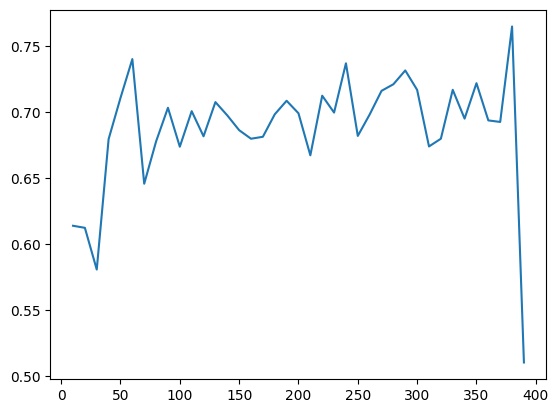

In [73]:
# Demonstrando independ√™ncia da m√©trica com a propor√ß√£o entre as categorias:
tot = 400
n = 10
x = range(10, 400, 10)
sc = []
for n in x:
    z = pd.concat([test_df.query('violento_final == 0').sample(tot - n), test_df.query('violento_final == 1').sample(n)])
    sc.append(ml.geomean_hit_rate(z['violento_final'], z['hate_score'] > 0.5))

pl.plot(x, sc)
pl.show()